##Calculate and store the ratings of the images in the corresponding folder
##Follow the environment eval_score.yaml

In [15]:
import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
import os, shutil
from torch import autocast
from torch.cuda.amp import GradScaler
from transformers import CLIPModel, CLIPProcessor, AutoProcessor, AutoModel
import PIL.Image
import random
import matplotlib.pyplot as plt

In [3]:
CLIP_PATH = 'D:/Alignment_with_one_sampling/stable_diffusion/CLIPModel/clip-vit-large-patch14'
AESTHETIC_PATH = "D:/Alignment_with_one_sampling/stable_diffusion/Aesthetic_Scorer/sac+logos+ava1-l14-linearMSE.pth"
HPS_V2_PATH = "D:/Alignment_with_one_sampling/stable_diffusion/HPS_v2_Scorer/HPS_v2_compressed.pt"
PICK_SCORE_PATH = "D:/Alignment_with_one_sampling/stable_diffusion/PickScore_v1"

In [4]:
def load_pth_files_to_list(directory):
    tensor_list = []
    
    for filename in tqdm.tqdm(os.listdir(directory)):
        if filename.endswith(".pth"):
            file_path = os.path.join(directory, filename)
            tensor = torch.load(file_path,weights_only=True)
            tensor_list.append(tensor)  
             
    return tensor_list

In [5]:
class MLPDiff(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(768, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )

    def forward(self, embed):
        return self.layers(embed)

class AestheticScorerDiff(torch.nn.Module):
    def __init__(self, dtype):
        super().__init__()
        self.clip = CLIPModel.from_pretrained(CLIP_PATH)
        self.mlp = MLPDiff()
        state_dict = torch.load(AESTHETIC_PATH)
        self.mlp.load_state_dict(state_dict)
        self.dtype = dtype
        self.eval()

    def __call__(self, images):
        device = next(self.parameters()).device
        embed = self.clip.get_image_features(pixel_values=images)
        embed = embed / torch.linalg.vector_norm(embed, dim=-1, keepdim=True)
        return self.mlp(embed).squeeze(1)

def aesthetic_loss_fn(device=None,
                     inference_dtype=None):
    scorer = AestheticScorerDiff(dtype=inference_dtype).to(device)
    scorer.requires_grad_(False)
    processor = CLIPProcessor.from_pretrained(CLIP_PATH)
    def loss_fn(im_pix_un, prompts=None):
        im_pix = processor(images=im_pix_un).to(device)
        input_pix = im_pix['pixel_values']
        input_pix = torch.tensor(np.stack(input_pix)).to(device)
        rewards = scorer(input_pix)
        return rewards
        
    return loss_fn

In [6]:
def hps_loss_fn(inference_dtype=None, device=None):
    import hpsv2
    from hpsv2.src.open_clip import create_model_and_transforms, get_tokenizer

    model_name = "ViT-H-14"
    model, preprocess_train, preprocess_val = create_model_and_transforms(
        model_name,
        "D:/Alignment_with_one_sampling/stable_diffusion/CLIPModel/laion2B-s32B-b79K/open_clip_pytorch_model.bin",
        precision=inference_dtype,
        device=device,
        jit=False,
        force_quick_gelu=False,
        force_custom_text=False,
        force_patch_dropout=False,
        force_image_size=None,
        pretrained_image=False,
        image_mean=None,
        image_std=None,
        light_augmentation=True,
        aug_cfg={},
        output_dict=True,
        with_score_predictor=False,
        with_region_predictor=False
    )    
    
    checkpoint_path = HPS_V2_PATH
    checkpoint = torch.load(checkpoint_path, map_location=device) 
    model.load_state_dict(checkpoint['state_dict'])
    tokenizer = get_tokenizer(model_name)
    model = model.to(device, dtype=inference_dtype)
    model.eval()
        
    def loss_fn(img_path, prompts):    
        with torch.no_grad():
            image = preprocess_val(img_path).unsqueeze(0).to(device=device, non_blocking=True)
            text = tokenizer(prompts).to(device=device, non_blocking=True)
            outputs = model(image, text)
        image_features, text_features = outputs["image_features"], outputs["text_features"]
        logits_per_image = image_features @ text_features.T
        hps_score = torch.diagonal(logits_per_image)
        return hps_score
    
    return loss_fn

In [7]:
def pick_loss_fn(inference_dtype=None, device=None):
    from open_clip import get_tokenizer

    processor_path = "D:/Alignment_with_one_sampling/stable_diffusion/CLIPModel/laion2B-s32B-b79K"
    processor = AutoProcessor.from_pretrained(processor_path)

    model_name = "ViT-H-14"
    model = AutoModel.from_pretrained(PICK_SCORE_PATH) 
    
    tokenizer = get_tokenizer(model_name)
    model = model.to(device, dtype=inference_dtype)
    model.eval()

    def loss_fn(im_pix_un, prompts):    
        with torch.no_grad():
            caption = tokenizer(prompts)
            caption = caption.to(device)

            im_pix = processor(images=im_pix_un)
        
            input_pix = im_pix['pixel_values']
            input_pix = torch.tensor(np.stack(input_pix)).to(device)
            image_embs = model.get_image_features(input_pix)
            image_embs = image_embs / torch.norm(image_embs, dim=-1, keepdim=True)
        
            text_embs = model.get_text_features(caption)
            text_embs = text_embs / torch.norm(text_embs, dim=-1, keepdim=True)
            scores = model.logit_scale.exp() * (text_embs @ image_embs.T)[0]
        return  scores
    
    return loss_fn

In [8]:
def save_png_files_by_name(file_name, source_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    source_path = os.path.join(source_dir, file_name)
    with PIL.Image.open(source_path) as img:
        target_path = os.path.join(target_dir, file_name)
        img.save(target_path)

In [9]:
paper_prompt = ['goldfish','golden retriever','strawberry','giant panda','castle','convertible','reflex camera','viaduct','pomegranate','head cabbage','teddy','sax','parachute','notebook','grand piano','airship','snow leopard','red fox','American lobster','bulbul',
                'hummingbird','maillot','wombat','Tibetan mastiff','marmot','beacon','crib','home theater','lipstick','maze','missile','mortarboard','planetarium','scabbard','snowplow','space shuttle','water tower','volcano','school bus','fountain','burrito',
                'throne','window shade','military uniform','tusker','valley','yawl','sea anemone','palace','hot pot']
paper_idx = [1,207,949,388,483,511,759,888,957,936,850,776,701,681,579,405,289,277,122,16,95,638,106,244,336,437,520,598,629,646,657,667,727,777,803,812,900,980,779,562,965,857,905,652,101,979,914,108,698,926]

In [ ]:
for rest1 in tqdm.tqdm(range(len(paper_idx))):
    class_idx = paper_idx[rest1]
    nv_directory = 'nv_out_512_CFG_s/class{}'.format(class_idx)
    tensor_list = load_pth_files_to_list(nv_directory)
    nv_gap_origin = torch.stack(tensor_list)
    torch.save(nv_gap_origin,"concate_nv_gap/512_class{}_2.23_0to10000.pth".format(class_idx))

In [ ]:
#Calculate pick_score and store it
device=torch.device('cuda')
pick_score = pick_loss_fn(torch.float32,device)

for rest1 in tqdm.tqdm(range(len(paper_idx))):
    class_idx = paper_idx[rest1]
    input_dir = 'out_512_CFG_s/class{}'.format(class_idx)
    cur_prompt = paper_prompt[rest1]
    pick_score_list = []
    for i in tqdm.tqdm(range(0, 10000)):
        file_name = f'{i:06d}.png'
        source_path = os.path.join(input_dir, file_name)
        image = PIL.Image.open(source_path)
        score = pick_score(image,cur_prompt)
        pick_score_list.append(score)

    cur_score_store = torch.stack(pick_score_list)
    torch.save(cur_score_store,"image_score/pick_score/512_class{}_2.23_0to10000.pth".format(class_idx))
    del cur_score_store
    torch.cuda.empty_cache()

del pick_score
torch.cuda.empty_cache()

In [ ]:
#Calculate hpv2_score and store it
device=torch.device('cuda')
hpv2_score = hps_loss_fn(torch.float32,device)

for rest1 in tqdm.tqdm(range(len(paper_idx))):
    class_idx = paper_idx[rest1]
    input_dir = 'out_512_CFG_s/class{}'.format(class_idx)
    cur_prompt = paper_prompt[rest1]

    file_path = "image_score/hpv2_score/512_class{}_2.23_0to10000.pth".format(class_idx)
    if os.path.exists(file_path):
        print("the file exits")
        continue


    pick_score_list = []
    for i in range(0, 10000):
        file_name = f'{i:06d}.png'
        source_path = os.path.join(input_dir, file_name)
        image = PIL.Image.open(source_path)
        score = hpv2_score(image,cur_prompt)
        pick_score_list.append(score)

    cur_score_store = torch.stack(pick_score_list)
    torch.save(cur_score_store,"image_score/hpv2_score/512_class{}_2.23_0to10000.pth".format(class_idx))
    del cur_score_store
    torch.cuda.empty_cache()

del hpv2_score
torch.cuda.empty_cache()

In [ ]:
#Calculate aesthetic_score and store it
device=torch.device('cuda')
aesthetic_score = aesthetic_loss_fn(device,torch.float32)

for rest1 in tqdm.tqdm(range(len(paper_idx))):
    class_idx = paper_idx[rest1]
    input_dir = 'out_512_CFG_s/class{}'.format(class_idx)
    cur_prompt = paper_prompt[rest1]
    print(cur_prompt)

    pick_score_list = []
    for i in tqdm.tqdm(range(0, 10000)):
        file_name = f'{i:06d}.png'
        source_path = os.path.join(input_dir, file_name)
        image = PIL.Image.open(source_path)
        score = aesthetic_score(image)
        pick_score_list.append(score)

    cur_score_store = torch.stack(pick_score_list)
    print(cur_score_store.shape)
    torch.save(cur_score_store,"image_score/aesthetic_score/512_class{}_2.23_0to10000.pth".format(class_idx))
    print("score has been saved as image_score/aesthetic_score/512_class{}_2.23_0to10000.pth".format(class_idx))
    del cur_score_store
    torch.cuda.empty_cache()

del aesthetic_score
torch.cuda.empty_cache()

##Compare our method with Best-of-N

In [14]:
score_over_time = []
for i in range(81):
    class_mean = []
    for rest1 in range(len(paper_idx)):  
        class_idx = paper_idx[rest1]
        nv_gap_origin = torch.load("D:/autoguidance/concate_nv_gap/512_class{}_2.23_0to10000.pth".format(class_idx),weights_only=True).cpu()
        cur_pick_score = torch.load("D:/autoguidance/image_score/pick_score/512_class{}_2.23_0to10000.pth".format(class_idx),weights_only=True).cpu().squeeze(1)
        cur_total_step = 0
        for iter_num in range(10):
            random_number = random.sample(range(10000), 10000-i*100)
            random_pick_score = cur_pick_score[random_number]  
            cur_nv_gap_origin = nv_gap_origin[random_number]
            nv_gap_classify = cur_nv_gap_origin.permute(1,0,2)

            nv_gap_time_steps = nv_gap_classify[:5]
            nv_gap_time_steps = nv_gap_time_steps.permute(1,0,2)
            nv_gap_time_steps_mean = torch.mean(torch.mean(nv_gap_time_steps,dim=-1),dim=-1)
            sorted_mean,idx_mean = torch.sort(nv_gap_time_steps_mean,descending=True)
            top10_idx = idx_mean[:1000]
            cur_mean_score = torch.mean(random_pick_score[top10_idx]).item()

            cur_total_step += cur_mean_score
        class_mean.append(cur_total_step/10)
    score_over_time.append(sum(class_mean)/len(paper_idx))

pick_our_score = []
for i in range(81):
    pick_our_score.append(score_over_time[80-i])

In [17]:
score_over_time = []
for i in range(81):
    class_mean = []
    for rest1 in range(len(paper_idx)):  
        class_idx = paper_idx[rest1]
        cur_pick_score = torch.load("D:/autoguidance/image_score/pick_score/512_class{}_2.23_0to10000.pth".format(class_idx),weights_only=True).cpu().squeeze(1)
        cur_AES_score = torch.load("D:/autoguidance/image_score/aesthetic_score/512_class{}_2.23_0to10000.pth".format(class_idx),weights_only=True).cpu().squeeze(1)
        cur_total_step = 0
        for iter_num in range(10):
            random_number = random.sample(range(10000), 1965-i*12)
            random_score = cur_AES_score[random_number]
            random_pick_score = cur_pick_score[random_number]  

            sort_score,sort_idx = torch.sort(random_score,descending=True)
            cur_score = random_pick_score[sort_idx[:1000]]
            cur_mean_score = torch.mean(cur_score).item()

            cur_total_step += cur_mean_score
        class_mean.append(cur_total_step/10)
    score_over_time.append(sum(class_mean)/len(paper_idx))

pick_bestN_score = []
for i in range(81):
    pick_bestN_score.append(score_over_time[80-i])

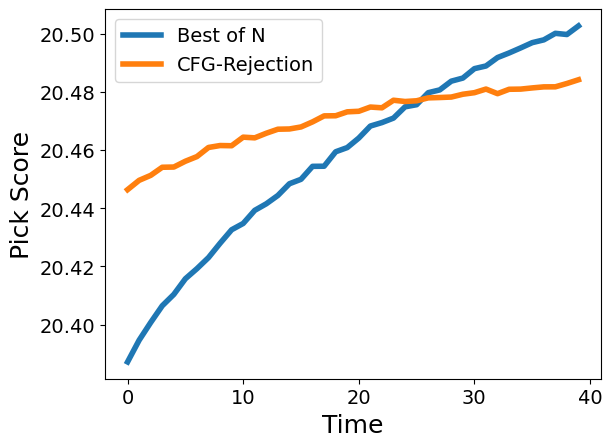

In [18]:
plt.plot(pick_bestN_score[:40],label='Best of N',linewidth=4)
plt.plot(pick_our_score[:40],label='CFG-Rejection',linewidth=4)
plt.legend(fontsize=14)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Pick Score", fontsize=18)
plt.tick_params(axis='both', labelsize=14)